In [43]:
#Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
#from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report, confusion_matrix

import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

In [44]:
watch_data=pd.read_csv("watches_cleaned.csv")

In [45]:
watch_data.columns

Index(['Name', 'Price(₹)', 'Brand', 'Ratings', 'Reviews', 'Type', 'Gender',
       'Price_Range'],
      dtype='object')

In [46]:
# Store encoders for categorical columns
encoders = {}
for col in watch_data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    watch_data[col] = le.fit_transform(watch_data[col])
    encoders[col] = le


In [47]:
watch_data.head()

,Name,Price(₹),Brand,Ratings,Reviews,Type,Gender,Price_Range
0,78,209,146,2.0,71,0,0,1
1,929,279,92,4.5,93,0,0,1
2,882,386,125,2.6,235,1,3,1
3,814,1359,53,1.3,394,0,5,0
4,873,900,36,4.4,169,0,5,3


In [48]:
X = watch_data[['Type', 'Ratings', 'Reviews', 'Brand', 'Gender']]
y = watch_data['Price_Range']

In [49]:
#Train-Test Split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42) 

In [50]:
print("X_Training Data",len(X_train))
print("X_Testing Data",len(X_test))
print("Y_Training Data",len(y_train))
print("Y_Testing Data",len(y_test))

X_Training Data 2272
X_Testing Data 568
Y_Training Data 2272
Y_Testing Data 568


In [51]:
#Scaling 
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [52]:
watch_data.head()

,Name,Price(₹),Brand,Ratings,Reviews,Type,Gender,Price_Range
0,78,209,146,2.0,71,0,0,1
1,929,279,92,4.5,93,0,0,1
2,882,386,125,2.6,235,1,3,1
3,814,1359,53,1.3,394,0,5,0
4,873,900,36,4.4,169,0,5,3


In [64]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

results = []
trained_models = {}
for name, model in models.items():
    print(f"\n Training {name} Model")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")

    results.append([name, accuracy, precision, recall, f1])
    
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    #print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    trained_models[name] = model
# Creating DataFrame 
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score"])
results_df.set_index('Model', inplace=True)
results_df.sort_values(by='Accuracy', ascending=False, inplace=True)


print("\n Model Performance Summary:\n")
print("\nResult:\n", results_df)




 Training Logistic Regression Model
Accuracy: 0.4824
Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.60      0.47       134
           1       0.56      0.78      0.65       246
           2       0.00      0.00      0.00        14
           3       0.00      0.00      0.00        90
           4       0.12      0.03      0.04        76
           5       0.00      0.00      0.00         8

    accuracy                           0.48       568
   macro avg       0.18      0.23      0.19       568
weighted avg       0.35      0.48      0.40       568


 Training SVM Model
Accuracy: 0.6320
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.60      0.57       134
           1       0.65      0.93      0.76       246
           2       0.00      0.00      0.00        14
           3       0.66      0.37      0.47        90
           4       0.94      0.21      0.34   

In [54]:
#  XGBoost with hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 1, 2],
    'min_child_weight': [1, 3, 5]
}

xgb = XGBClassifier(
    n_estimators=300, learning_rate=0.05, max_depth=6,subsample=0.8, colsample_bytree=0.8,
    use_label_encoder=False, eval_metric='mlogloss', random_state=42 )

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1
)


In [55]:
grid_search.fit(X_train, y_train)
best_xgb = grid_search.best_estimator_
models["XGBoost (Tuned)"] = best_xgb

print("Best XGBoost Params:", grid_search.best_params_)

results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score"])
print("\nResult_DF :\n",results_df)


Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best XGBoost Params: {'colsample_bytree': 0.7, 'gamma': 1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 200}

Result_DF :
                  Model  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression  0.482394   0.348646  0.482394  0.398330
1                  SVM  0.632042   0.640481  0.632042  0.586969
2                  KNN  0.656690   0.657356  0.656690  0.646012
3        Random Forest  0.783451   0.761209  0.783451  0.767401
4              XGBoost  0.809859   0.801818  0.809859  0.800129


In [56]:
# Predicting on test data
y_pred = best_xgb.predict(X_test)
print("Predictions:", y_pred[:20])   

xgb_acc = accuracy_score(y_test, y_pred)
print(f"\nTuned XGBoost Accuracy: {xgb_acc:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Predictions: [4 3 1 1 4 3 4 3 1 1 0 1 3 4 1 1 0 1 0 1]

Tuned XGBoost Accuracy: 0.8204
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.88      0.80       134
           1       0.91      1.00      0.95       246
           2       0.20      0.07      0.11        14
           3       0.89      0.52      0.66        90
           4       0.69      0.72      0.71        76
           5       0.00      0.00      0.00         8

    accuracy                           0.82       568
   macro avg       0.57      0.53      0.54       568
weighted avg       0.81      0.82      0.80       568

Confusion Matrix:
 [[118   1   2   5   8   0]
 [  1 245   0   0   0   0]
 [  2   2   1   0   9   0]
 [ 24  11   0  47   8   0]
 [ 17   2   1   1  55   0]
 [  0   7   1   0   0   0]]


In [57]:
# Best parameters and CV score
print("\n Best Parameters:", grid_search.best_params_)
print(" Best CV F1-Score:", grid_search.best_score_)


 Best Parameters: {'colsample_bytree': 0.7, 'gamma': 1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 200}
 Best CV F1-Score: 0.7926924198538646


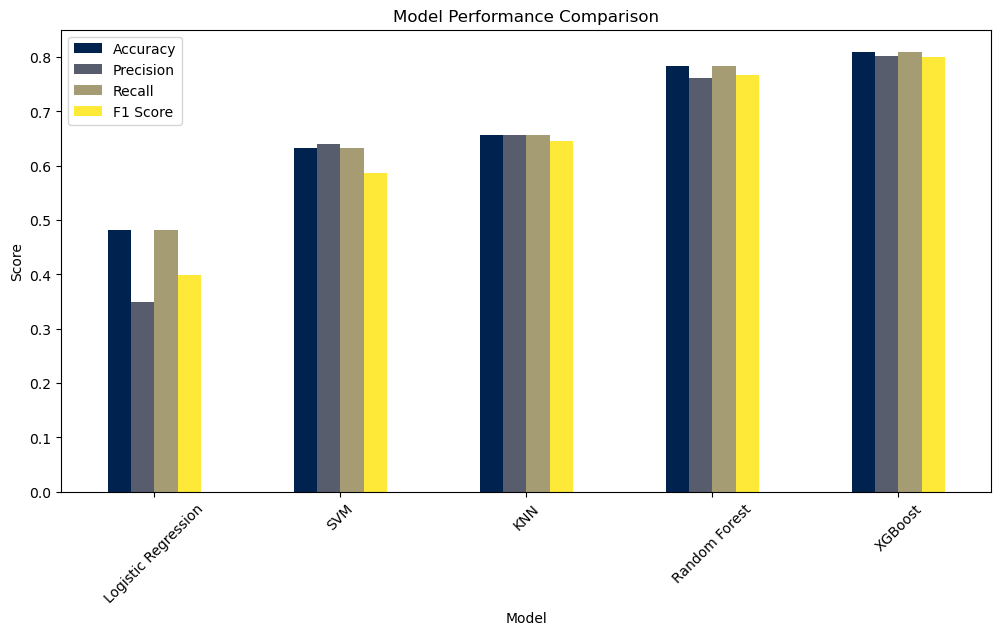

In [58]:

results_df.set_index('Model', inplace=True)

results_df[['Accuracy','Precision','Recall','F1 Score']].plot( kind='bar', colormap='cividis', figsize=(12,6))

plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc="upper left")
plt.show()


In [63]:
import gradio as gr
import numpy as np

# Assume these are already defined:
# trained_models -> dict of trained models
# encoders -> dict of LabelEncoders: {'Type', 'Brand', 'Gender', 'Price_Range'}
# scaler -> fitted scaler used for features

def predict_price_range(model_name, type_, ratings, reviews, brand, gender):
    try:
        # Convert numeric inputs
        ratings = float(ratings)
        reviews = float(reviews)

        # Validate categorical inputs
        for col_name, value in zip(['Type', 'Brand', 'Gender'],
                                   [type_, brand, gender]):
            if value not in encoders[col_name].classes_:
                return f"Error: '{value}' not found in {col_name} encoder"

        # Encode categorical features
        type_enc = encoders['Type'].transform([type_])[0]
        brand_enc = encoders['Brand'].transform([brand])[0]
        gender_enc = encoders['Gender'].transform([gender])[0]

        # Build input row (ensure order matches training)
        row = [[type_enc, ratings, reviews, brand_enc, gender_enc]]
        row_scaled = scaler.transform(row)

        # Select model
        model = trained_models[model_name]

        # Predict
        pred_class = model.predict(row_scaled)[0]

        # Decode target
        price_range = encoders['Price_Range'].inverse_transform([pred_class])[0]

        return f"Predicted Price Range: {price_range}"

    except Exception as e:
        return f"⚠️ Error during prediction: {str(e)}"

# Gradio Interface
demo = gr.Interface(
    fn=predict_price_range,
    inputs=[
        gr.Dropdown(list(trained_models.keys()), label="Model"),
        gr.Dropdown(list(encoders['Type'].classes_), label="Type"),
        gr.Number(label="Ratings"),
        gr.Number(label="Reviews"),
        gr.Dropdown(list(encoders['Brand'].classes_), label="Brand"),
        gr.Dropdown(list(encoders['Gender'].classes_), label="Gender"),
    ],
    outputs="text",
    title="Watch Price Range Predictor"
)

demo.launch()


* Running on local URL:  http://127.0.0.1:7864
* To create a public link, set `share=True` in `launch()`.
